# Configuration

In [1]:
# Import libraries
import pandas            as pd
import matplotlib.pyplot as plt
import numpy             as np
import os                as os
import seaborn           as sns
import time              as time

from amberdata_derivatives import AmberdataDerivatives

import warnings
warnings.filterwarnings("ignore")

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Retrieve API key
API_KEY = os.getenv("API_KEY")

# Amberdata SDK

In [2]:
amberdata_client = AmberdataDerivatives(api_key=API_KEY)

amberdata_client.get

# Deribit instruments

In [3]:
# Use this endpoint to get back all of the available instruments on deribit
instruments = pd.DataFrame(amberdata_client.get_instruments_information(exchange='deribit')['payload']['data'])
instruments.head(10)

,currency,endDate,exchange,expiration,instrument,multiplier,nativeInstrument,putCall,strike
0,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-48000.0-C,1,BTC-10SEP24-48000-C,C,48000.0
1,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-48000.0-P,1,BTC-10SEP24-48000-P,P,48000.0
2,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-49000.0-C,1,BTC-10SEP24-49000-C,C,49000.0
3,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-49000.0-P,1,BTC-10SEP24-49000-P,P,49000.0
4,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-50000.0-C,1,BTC-10SEP24-50000-C,C,50000.0
5,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-50000.0-P,1,BTC-10SEP24-50000-P,P,50000.0
6,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-51000.0-C,1,BTC-10SEP24-51000-C,C,51000.0
7,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-51000.0-P,1,BTC-10SEP24-51000-P,P,51000.0
8,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-51500.0-C,1,BTC-10SEP24-51500-C,C,51500.0
9,BTC,1725942360000,deribit,1725955200000,DERIBIT-BTC-10SEP24-51500.0-P,1,BTC-10SEP24-51500-P,P,51500.0


# Put/Call trade distribution

Text(0.5, 1.0, 'BTC Put Call Trade Distribution Over the Past 7 Days')

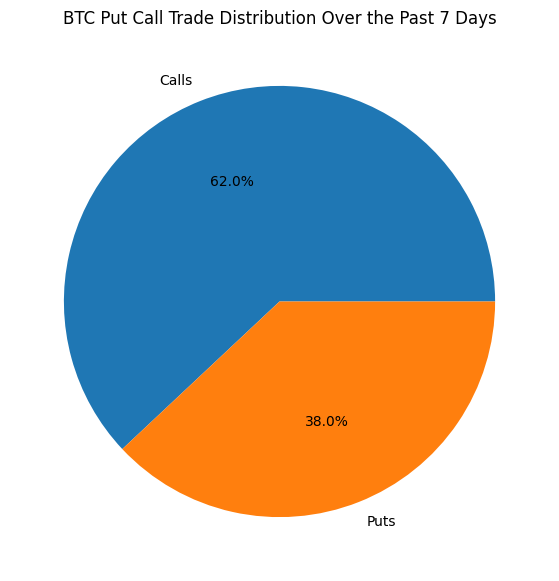

In [4]:
data = amberdata_client.get_trades_flow_block_volumes(exchange='deribit', currency='btc')
data = pd.DataFrame(data['payload']['data'])
data = data.groupby("putCall").sum()

plt.figure(figsize=(15, 7))
labels = ['Calls', 'Puts']
plt.pie(data.contractVolume.values.flatten(), labels=labels, autopct='%1.1f%%')
plt.title("BTC Put Call Trade Distribution Over the Past 7 Days")

# Block trade bar plot

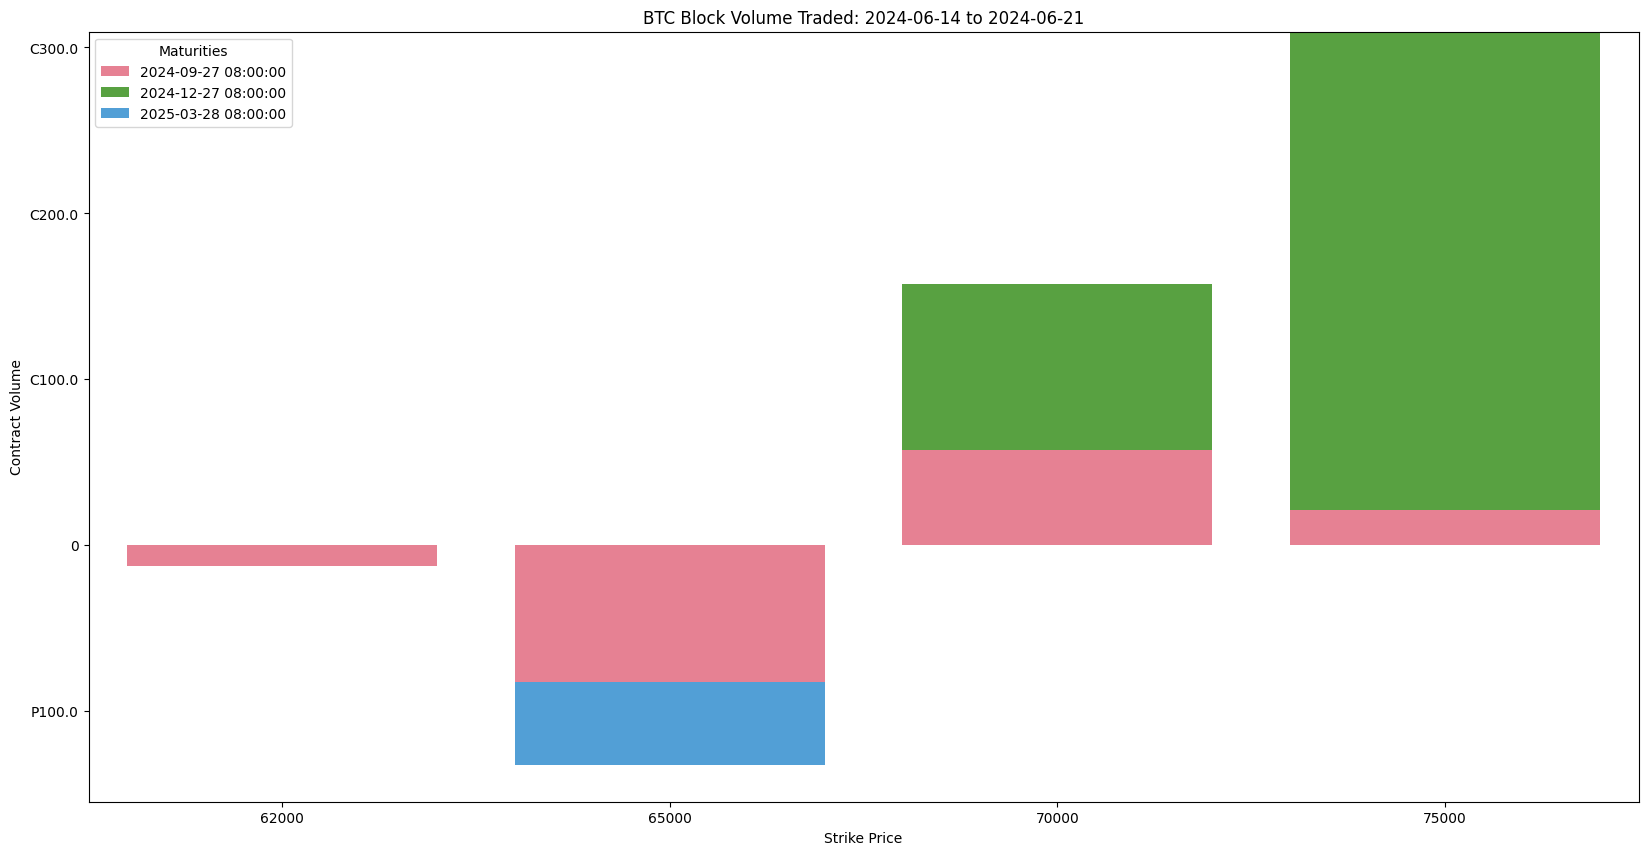

In [5]:
data = amberdata_client.get_trades_flow_block_volumes(exchange='deribit', currency='btc', startDate='2024-06-14', endDate='2024-06-21')
data = pd.DataFrame(data['payload']['data'])

data['expirationTimestamp'] = pd.to_datetime(data.expirationTimestamp, unit='ms')
data['adj_volume'] = np.where(data.putCall=='P', -data.contractVolume, data.contractVolume)

# only look at expiries that are valid today 
data = data[data.expirationTimestamp >= pd.to_datetime(time.time(), unit='s')]

exps = set(data.expirationTimestamp)
store = []
for exp in exps:
    sub = data[data.expirationTimestamp == exp].reset_index(drop=True)    
    sub = sub[['expirationTimestamp', 'strike', 'putCall', 'adj_volume']]
    # filter out strikes to allow for better visual plotting
    sub = sub[(sub.strike > 60_000) & (sub.strike < 80_000)]
    sub['maturity'] = exp
    store.append(sub)
    
combined_df = pd.concat(store)
pivot_df = combined_df.pivot_table(index='strike', columns='maturity', values='adj_volume', aggfunc='sum').fillna(0)    

fig, ax = plt.subplots(figsize=(20, 10))

# Define colors for each maturity
colors = sns.color_palette("husl", len(pivot_df.columns))
maturities = pivot_df.columns

# Stack the bars
bottom = pd.Series([0]*len(pivot_df), index=pivot_df.index)
for maturity, color in zip(maturities, colors):
    sns.barplot(x=pivot_df.index, y=pivot_df[maturity], bottom=bottom, label=maturity, color=color)
    bottom += pivot_df[maturity]

ax.legend(title='Maturities')    
ax.set_xlabel('Strike Price')
ax.set_ylabel('Contract Volume')
yticks = ax.get_yticks()
yticklabels = ['C' + str(y) if y > 0 else 'P' + str(-y) if y < 0 else '0' for y in yticks]
ax.set_yticklabels(yticklabels);
plt.title("BTC Block Volume Traded: 2024-06-14 to 2024-06-21");

# Top 10 instruments traded

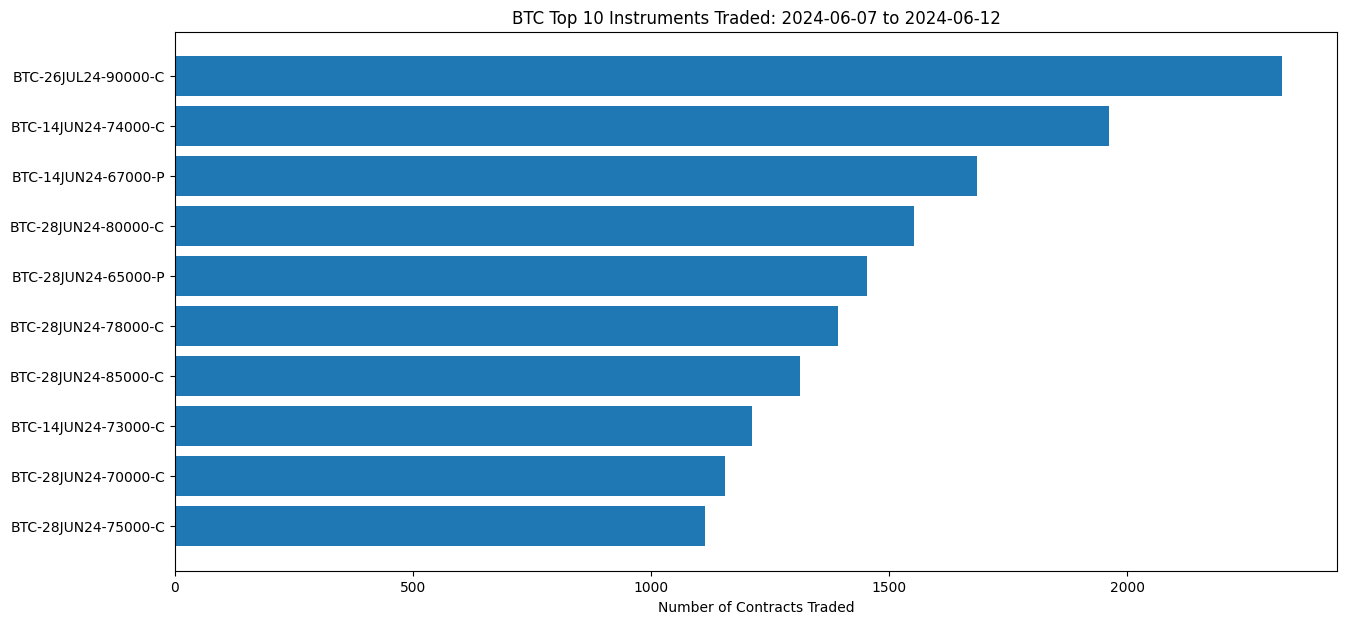

In [6]:
data = amberdata_client.get_instruments_most_traded(exchange='deribit', currency='BTC', startDate='2024-06-07', endDate='2024-06-12')
data = pd.DataFrame(data['payload']['data'])

plt.figure(figsize=(15, 7))
plt.barh(data.instrument[:10], data.contractVolume[:10][::-1])
plt.title("BTC Top 10 Instruments Traded: 2024-06-07 to 2024-06-12")
plt.xlabel("Number of Contracts Traded");

# Trade distribution

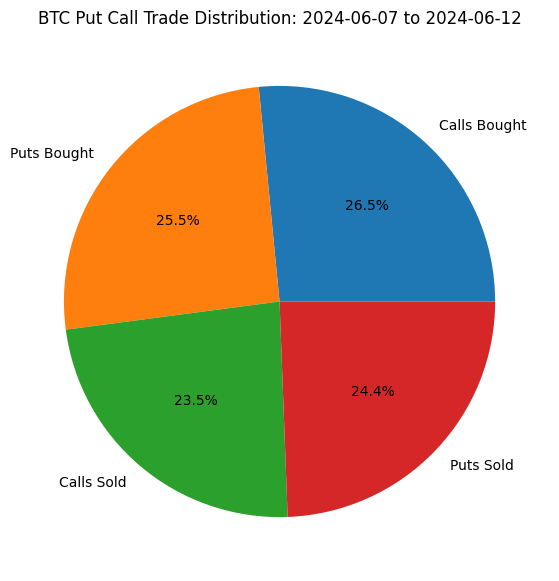

In [7]:
data = amberdata_client.get_trades_flow_put_call_distribution(exchange='deribit', currency='BTC', startDate='2024-06-07', endDate='2024-06-12')
data = pd.DataFrame(data['payload']['data'])

plt.figure(figsize=(15, 7))
labels = ['Calls Bought', 'Puts Bought', 'Calls Sold', 'Puts Sold']
plt.pie(data.iloc[:, :4].values.flatten(), labels=labels, autopct='%1.1f%%')
plt.title("BTC Put Call Trade Distribution: 2024-06-07 to 2024-06-12");

# Normalized gamma USD

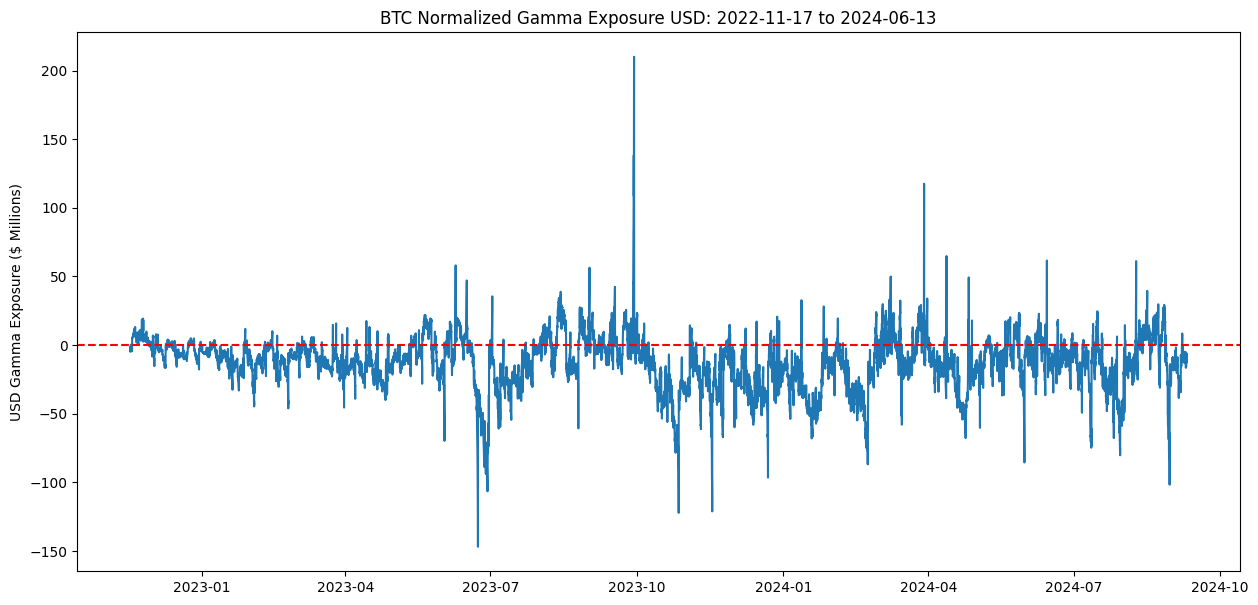

In [8]:
data = amberdata_client.get_trades_flow_gamma_exposures_normalized_usd(exchange='deribit', currency='btc')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.snapshotTimestamp, unit='ms')

plt.figure(figsize=(15, 7))
plt.plot(data.normalizedGammaUSD/1_000_000)
plt.axhline(0, linestyle='--', c='r')
plt.title("BTC Normalized Gamma Exposure USD: 2022-11-17 to 2024-06-13")
plt.ylabel("USD Gamma Exposure ($ Millions)");

# GEX snapshots across different instruments

In [9]:
data = amberdata_client.get_trades_flow_gamma_exposures_snapshots(exchange='deribit', currency='btc', startDate='2024-01-01', endDate='2024-01-02')
data = pd.DataFrame(data['payload']['data'])
data

,currency,dealerNetInventory,dealerTotalInventory,exchange,expirationTimestamp,gammaLevel,indexPrice,instrumentNormalized,putCall,snapshotTimestamp,strike
0,BTC,-1.4,-2.0,deribit,1704182400000,0.000000,43541.53,DERIBIT-BTC-02JAN24-37000.0-P,P,1704150000000,37000
1,BTC,-6.7,-28.4,deribit,1704182400000,0.000000,43541.53,DERIBIT-BTC-02JAN24-37500.0-P,P,1704150000000,37500
2,BTC,-0.4,-14.2,deribit,1704182400000,0.000000,43541.53,DERIBIT-BTC-02JAN24-38000.0-P,P,1704150000000,38000
3,BTC,12.4,14.9,deribit,1704182400000,0.000000,43541.53,DERIBIT-BTC-02JAN24-38500.0-P,P,1704150000000,38500
4,BTC,4.2,11.2,deribit,1704182400000,0.000000,43541.53,DERIBIT-BTC-02JAN24-39000.0-P,P,1704150000000,39000
...,...,...,...,...,...,...,...,...,...,...,...
18707,BTC,0.0,0.0,deribit,1711699200000,0.000000,42272.16,DERIBIT-BTC-29MAR24-80000.0-P,P,1704067200000,80000
18708,BTC,174.9,439.9,deribit,1711699200000,0.004399,42272.16,DERIBIT-BTC-29MAR24-85000.0-C,C,1704067200000,85000
18709,BTC,0.0,0.0,deribit,1711699200000,0.000000,42272.16,DERIBIT-BTC-29MAR24-85000.0-P,P,1704067200000,85000
18710,BTC,22.3,321.5,deribit,1711699200000,0.003215,42272.16,DERIBIT-BTC-29MAR24-90000.0-C,C,1704067200000,90000


# Top 10 largest vega trades

Text(0.5, 0, 'Size Vega')

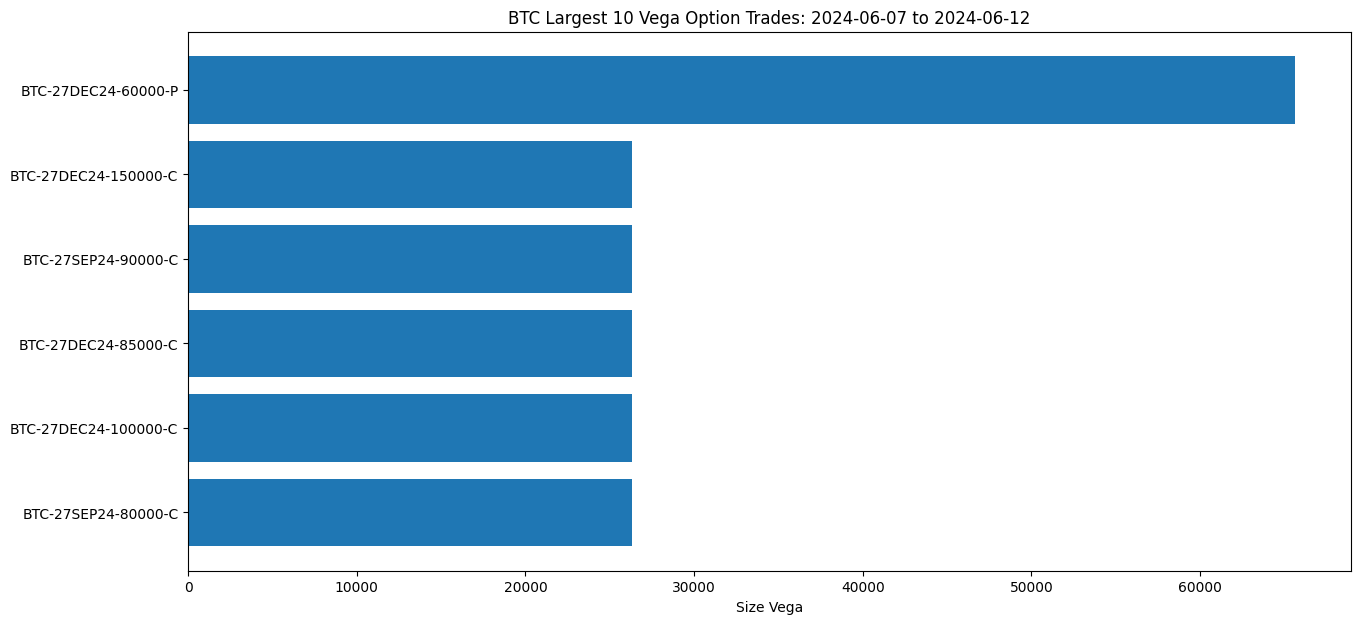

In [10]:
data = amberdata_client.get_options_scanner_top_trades(exchange='deribit', currency='btc', startDate='2024-06-07', endDate='2024-06-12')
data = pd.DataFrame(data['payload']['data'])

# only look at top 10 & sort by descending order 
data = data.sort_values("sizeVega", ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(15, 7))
plt.barh(data.instrument, data.sizeVega[::-1])
plt.title("BTC Largest 10 Vega Option Trades: 2024-06-07 to 2024-06-12")
plt.xlabel("Size Vega")